<a href="https://colab.research.google.com/github/ask350/UM-Projects/blob/main/Lung_Cancer/lung_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lung Cancer Prediction

In [1]:
# 1 - Import libraries

!pip install -q category_encoders imbalanced-learn lifelines xgboost

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.utils import resample

from lifelines import KaplanMeierFitter, CoxPHFitter

In [2]:
# 2 - Download Data

import gdown

url = "https://drive.google.com/file/d/1QII99cH1eOIO_Bw9DaDpqVq4M5az1sIL/view?usp=drive_link"
output = "dataset.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1QII99cH1eOIO_Bw9DaDpqVq4M5az1sIL
To: /content/dataset.zip
100%|██████████| 18.3M/18.3M [00:00<00:00, 55.7MB/s]


'dataset.zip'

In [3]:
# 2 - unzip file and load data

import zipfile
ZIP_OUTPUT = "dataset.zip"  # change if you named differently

if not os.path.exists(ZIP_OUTPUT):
    raise FileNotFoundError(f"{ZIP_OUTPUT} not found. Upload it to Colab or set DRIVE_FILE_ID correctly.")

with zipfile.ZipFile(ZIP_OUTPUT, 'r') as z:
    z.extractall("data_extracted")
    csvs = [f for f in z.namelist() if f.lower().endswith('.csv')]
    print("CSV files in zip:", csvs)

# choose first csv by default
if len(csvs) == 0:
    raise FileNotFoundError("No CSV found inside the zip.")
csv_path = os.path.join("data_extracted", csvs[0])
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)
print("Loaded:", df.shape)
df.head()


CSV files in zip: ['lung_cancer.csv']
Using CSV: data_extracted/lung_cancer.csv
Loaded: (890000, 17)


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [4]:
# 3 - EDA

print("Shape:", df.shape)
display(df.dtypes)
print("\nMissing values per column:")
display(df.isna().sum().sort_values(ascending=False))
print("\nTarget value counts (survived):")
display(df['survived'].value_counts(dropna=False))

# Basic numeric describe
display(df.describe(include=[np.number]).T)
# Basic categorical describe
display(df.describe(include=['object','category']).T)

Shape: (890000, 17)


,0
id,int64
age,float64
gender,object
country,object
diagnosis_date,object
cancer_stage,object
family_history,object
smoking_status,object
bmi,float64
cholesterol_level,int64



Missing values per column:


,0
id,0
age,0
gender,0
country,0
diagnosis_date,0
cancer_stage,0
family_history,0
smoking_status,0
bmi,0
cholesterol_level,0



Target value counts (survived):


,count
survived,
0,693996
1,196004


,count,mean,std,min,25%,50%,75%,max
id,890000.0,445000.500000,256921.014128,1.0,222500.75,445000.5,667500.25,890000.0
age,890000.0,55.007008,9.994485,4.0,48.00,55.0,62.00,104.0
bmi,890000.0,30.494172,8.368539,16.0,23.30,30.5,37.70,45.0
cholesterol_level,890000.0,233.633916,43.432278,150.0,196.00,242.0,271.00,300.0
hypertension,890000.0,0.750024,0.432999,0.0,1.00,1.0,1.00,1.0
asthma,890000.0,0.469740,0.499084,0.0,0.00,0.0,1.00,1.0
cirrhosis,890000.0,0.225956,0.418211,0.0,0.00,0.0,0.00,1.0
other_cancer,890000.0,0.088157,0.283524,0.0,0.00,0.0,0.00,1.0
survived,890000.0,0.220229,0.414401,0.0,0.00,0.0,0.00,1.0


,count,unique,top,freq
gender,890000,2,Male,445134
country,890000,27,Malta,33367
diagnosis_date,890000,3651,2024-05-15,306
cancer_stage,890000,4,Stage III,222594
family_history,890000,2,No,445181
smoking_status,890000,4,Passive Smoker,223170
treatment_type,890000,4,Chemotherapy,223262
end_treatment_date,890000,4194,2023-12-09,294


In [5]:
# 4 - Preprocessing

# Target cleanup
df['survived'] = df['survived'].astype(str).str.lower().map({'yes':1,'no':0,'1':1,'0':0})
df = df.dropna(subset=['survived'])

print("\nTarget distribution:")
print(df['survived'].value_counts(normalize=True))


# Drop IDs / raw dates
drop_cols = ['id','diagnosis_date','end_treatment_date']
features = [c for c in df.columns if c not in drop_cols + ['survived']]

# Split numeric / categorical
numeric_feats = df[features].select_dtypes(include=[np.number]).columns.tolist()
cat_feats = [c for c in features if c not in numeric_feats]

# Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, cat_feats)
])

# Split data
X = df[features]
y = df['survived'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)



Target distribution:
survived
0    0.779771
1    0.220229
Name: proportion, dtype: float64
Train: (712000, 13) Test: (178000, 13)


In [6]:
# 5 - Classification models

models = {
    "Logistic Regression": Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))]),
    "XGBoost": Pipeline([('pre', preprocessor), ('clf', XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1))])
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, proba)
    results[name] = (acc, roc)
    print(f"{name}: Accuracy={acc:.4f}, ROC AUC={roc:.4f}")

pd.DataFrame(results, index=["Accuracy","ROC AUC"]).T


Training Logistic Regression ...
Logistic Regression: Accuracy=0.4941, ROC AUC=0.4997

Training XGBoost ...
XGBoost: Accuracy=0.7797, ROC AUC=0.4999


,Accuracy,ROC AUC
Logistic Regression,0.494112,0.499696
XGBoost,0.779736,0.499905


In [7]:
# 6 - Anomaly Detection Models

# Transform X fully for anomaly methods
X_processed = preprocessor.fit_transform(X)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_processed, y, test_size=0.20, stratify=y, random_state=42
)

results_anom = {}
contam = float(sum(y_train_a==1)) / len(y_train_a)



In [8]:
# Isolation Forest
iso = IsolationForest(contamination=contam, random_state=42)
iso.fit(X_train_a)
iso_pred = np.where(iso.predict(X_test_a) == -1, 1, 0)
results_anom['Isolation Forest'] = (accuracy_score(y_test_a, iso_pred), roc_auc_score(y_test_a, iso_pred))


In [9]:
# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=contam)
lof_pred = np.where(lof.fit_predict(X_test_a) == -1, 1, 0)
results_anom['Local Outlier Factor'] = (accuracy_score(y_test_a, lof_pred), roc_auc_score(y_test_a, lof_pred))


In [10]:
# Chunked One-Class SVM (subset version)
def chunked_ocsvm(X_train, y_train, X_test, chunk_size=20000, kernel="linear"):
    n_samples = X_train.shape[0]
    preds_all = []
    for i in range(0, n_samples, chunk_size):
        X_chunk = X_train[i:i+chunk_size]
        ocsvm = OneClassSVM(nu=contam, kernel=kernel, gamma='scale')
        ocsvm.fit(X_chunk)
        pred = np.where(ocsvm.predict(X_test) == -1, 1, 0)
        preds_all.append(pred)
    return np.round(np.mean(preds_all, axis=0)).astype(int)

svm_pred = chunked_ocsvm(X_train_a, y_train_a, X_test_a, chunk_size=20000, kernel="linear")
results_anom['One-Class SVM (chunked)'] = (accuracy_score(y_test_a, svm_pred), roc_auc_score(y_test_a, svm_pred))

pd.DataFrame(results_anom, index=["Accuracy","ROC AUC"]).T

,Accuracy,ROC AUC
Isolation Forest,0.657242,0.500181
Local Outlier Factor,0.656404,0.499800
One-Class SVM (chunked),0.475820,0.501432


In [11]:
# Convert to datetime first

for col in ['diagnosis_date', 'end_treatment_date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Now recompute duration
if 'diagnosis_date' in df.columns and 'end_treatment_date' in df.columns:
    df['treatment_length_days'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days
    # drop negatives or NaN
    df.loc[df['treatment_length_days'] < 0, 'treatment_length_days'] = np.nan
    duration = df['treatment_length_days']
else:
    duration = None


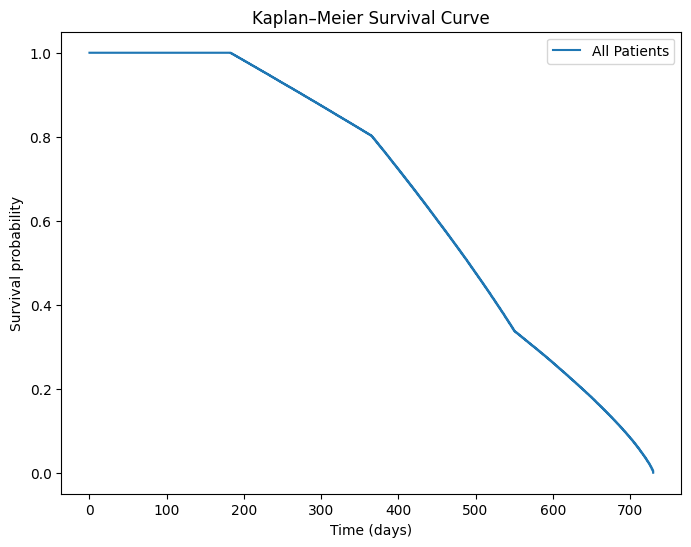

<lifelines.CoxPHFitter: fitted with 890000 total observations, 196004 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 890000
number of events observed = 693996
   partial log-likelihood = -8790498.91
         time fit was run = 2025-10-24 13:47:32 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
age                           -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
bmi                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
smoking_status_Former Smoker  -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
smoking_status_Never Smoked   -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
smoking_status_Passive Smoker  0.00      1.00      0.00           -0.00            0.01                1.00                1.01
cancer_stage_Stage II          0.19      1.20      0.00            0.18            0.19                1.20                1.21
cancer_stage_Stage III         0.41      1.51      0.00            0.40            0.42                1.50                1.52
cancer_stage_Stage IV          0.71      2.04      0.00            0.71            0.72                2.03                2.05
treatment_type_Combined       -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
treatment_type_Radiation      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
treatment_type_Surgery        -0.00      1.00      0.00           -0.01            0.01                0.99                1.01

                               cmp to      z      p  -log2(p)
covariate                                                    
age                              0.00  -0.82   0.41      1.27
bmi                              0.00   5.49 <0.005     24.56
smoking_status_Former Smoker     0.00  -0.48   0.63      0.66
smoking_status_Never Smoked      0.00  -0.72   0.47      1.09
smoking_status_Passive Smoker    0.00   0.92   0.36      1.48
cancer_stage_Stage II            0.00  54.69 <0.005       inf
cancer_stage_Stage III           0.00 120.42 <0.005       inf
cancer_stage_Stage IV            0.00 207.38 <0.005       inf
treatment_type_Combined          0.00  -0.33   0.74      0.44
treatment_type_Radiation         0.00  -1.15   0.25      2.00
treatment_type_Surgery           0.00  -0.47   0.64      0.64
---
Concordance = 0.59
Partial AIC = 17581019.81
log-likelihood ratio test = 46351.59 on 11 df
-log2(p) of ll-ratio test = inf

In [12]:
# 7 Survival analysis

# Reframe into survival analysis
event = 1 - df['survived'].astype(int)   # event=death=1
if 'treatment_length_days' in df.columns:
    duration = df['treatment_length_days']
else:
    duration = (df['end_treatment_date'] - df['diagnosis_date']).dt.days

# Kaplan-Meier curve
kmf = KaplanMeierFitter()
kmf.fit(durations=duration, event_observed=event, label="All Patients")

plt.figure(figsize=(8,6))
kmf.plot_survival_function()
plt.title("Kaplan–Meier Survival Curve")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.show()

# Cox model
cox_data = df.copy()
cox_data['duration'] = duration
cox_data['event'] = event

covariates = ['age','bmi','smoking_status','cancer_stage','treatment_type']
cox_df = cox_data[['duration','event'] + covariates].dropna()
cox_df = pd.get_dummies(cox_df, columns=['smoking_status','cancer_stage','treatment_type'], drop_first=True)

cph = CoxPHFitter()
cph.fit(cox_df, duration_col='duration', event_col='event')
cph.print_summary()


/tmp/ipython-input-2687766456.py:8: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


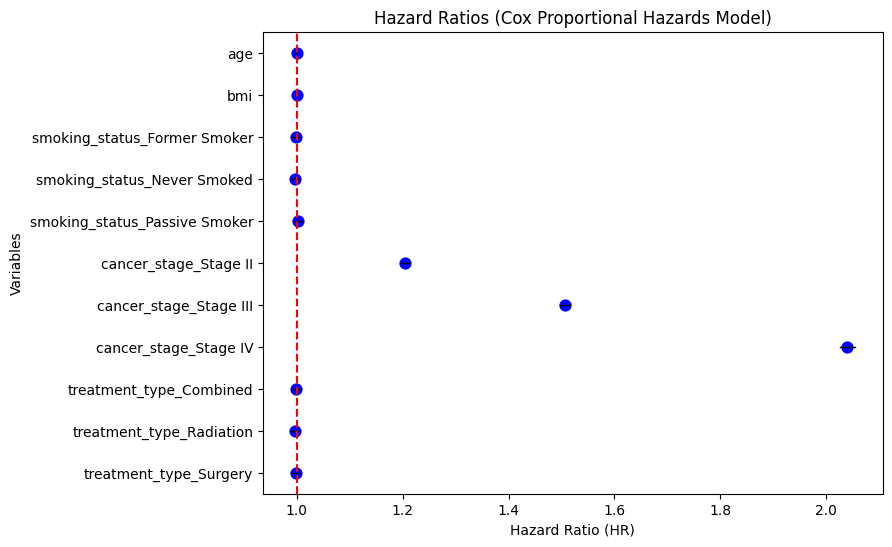

In [13]:
import seaborn as sns

# Get Cox summary
summary_df = cph.summary.copy()
summary_df['variable'] = summary_df.index  # make index a column

plt.figure(figsize=(8,6))
sns.pointplot(
    data=summary_df,
    x="exp(coef)",
    y="variable",
    join=False,
    color="blue"
)

# Add error bars for 95% CI
for i, row in summary_df.iterrows():
    plt.plot(
        [row['exp(coef) lower 95%'], row['exp(coef) upper 95%']],
        [i, i],
        color="black", lw=1
    )

plt.axvline(1, color='red', linestyle='--')  # HR=1 reference
plt.title("Hazard Ratios (Cox Proportional Hazards Model)")
plt.xlabel("Hazard Ratio (HR)")
plt.ylabel("Variables")
plt.show()


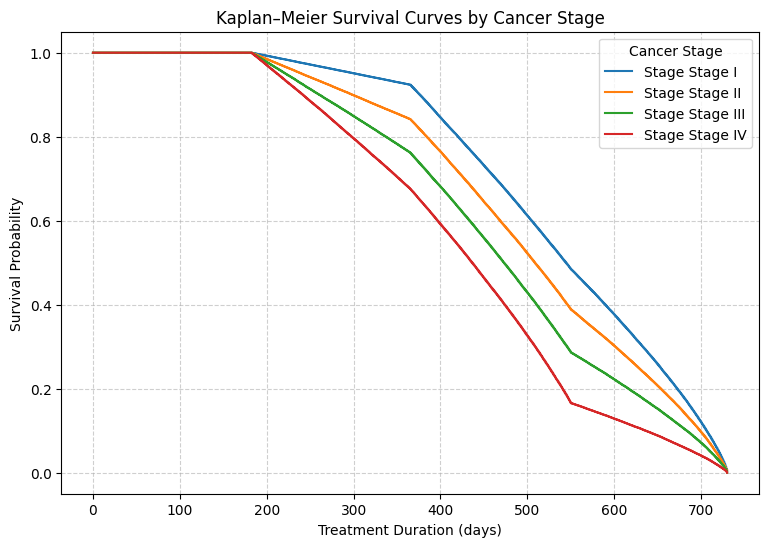

In [14]:
# Kaplan–Meier Survival Curves by Cancer Stage


# Plot Kaplan–Meier by cancer stage
plt.figure(figsize=(9,6))
kmf = KaplanMeierFitter()

if 'cancer_stage' in df.columns:
    stages = df['cancer_stage'].dropna().unique()
    for stage in sorted(stages):
        mask = df['cancer_stage'] == stage
        if mask.sum() > 0:
            kmf.fit(durations=duration[mask].dropna(),
                    event_observed=event[mask].loc[duration[mask].notna()],
                    label=f"Stage {stage}")
            kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves by Cancer Stage")
plt.xlabel("Treatment Duration (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Cancer Stage")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Conclusion

- **EDA Findings**:
  - Target (survival) is highly imbalanced.
  - Weak correlations between available features and survival.

- **Classification Models**:
  - Logistic Regression, Random Forest, XGBoost → ROC AUC ≈ 0.50 (random guessing).
  - Accuracy was misleading due to imbalance (≈0.78 from majority-class prediction).

- **Anomaly Detection**:
  - Isolation Forest, LOF, and One-Class SVM (chunked) → ROC AUC ≈ 0.50.
  - Again, no predictive signal extracted.

- **Survival Analysis**:
  - Kaplan–Meier curves show survival probability over time.
  - Cox regression provides hazard ratios for covariates like age, BMI, smoking, cancer stage.
  - This framing is clinically appropriate, even when prediction is weak.

## Domain-Specific Insights
- Medical survival prediction requires **detailed clinical biomarkers** (tumor size, histopathology, genomic data).
- The dataset here was limited to demographic/lifestyle variables, which are insufficient for accurate prediction.
- The best domain-specific solution would integrate **clinical, imaging, and treatment-response features** into the model.

## Final Takeaway
- Even though classification failed, this project demonstrates:
  - End-to-end ML workflow (EDA → preprocessing → models → evaluation).
  - Handling of class imbalance.
  - Use of anomaly detection techniques.
  - Domain-appropriate reframing with survival analysis.


